# Selecting the best features of our dataset using the Random Forest Classifier with PCA

In [1]:
#Importing our libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#importing our logistic regression model
from sklearn.linear_model import LogisticRegression

#importing ou feature selection model
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA

#metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

#utility libraries
from sklearn.model_selection import train_test_split
from matplotlib import rcParams
rcParams['figure.figsize'] = 14, 7
#erasing all spines
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.spines.left'] = False
rcParams['axes.spines.bottom'] = False




In [2]:
# Loading our data
data_base = pd.read_pickle('data_base.pkl')
info_cols = ['date',
 'home_team',
 'away_team',
 'season',
 'home_win' ]
# Splitting the data into train and test
X = data_base.loc[:, ~data_base.columns.isin(info_cols)] # excluding info_cols
y = data_base['home_win']

print(f'Feature set shape: {X.shape}, target series shape: {y.shape}')

# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# scaling the data with standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Feature set shape: (5999, 264), target series shape: (5999,)


In [3]:
#Importing our pickled models
lr = pd.read_pickle('models/LogisticRegression.pkl')
svm = pd.read_pickle('models/LinearSVC.pkl')
rf = pd.read_pickle('models/RandomForestClassifier.pkl')
gbc = pd.read_pickle('models/GradientBoostingClassifier.pkl')


### With our trained models on the base dataset, we will now see waht features the models has considered to be more important.

In [4]:
def get_feature_importance(model_importance, cols, n_best_features=10):
    """ Info:
     This function takes a model and returns a dataframe with the feature importance, and plots the top n_best_features.
      -----------------------------------------------------------------------------------------------------------------
       Input:
        model_importance: The attribute of the chosen model that contains the feature importance.
         cols: The columns of the feature set.
          n_best_features: The number of best features to plot and return.
        -----------------------------------------------------------------------------------------------------------------
            Output:
                importances: A dataframe with the feature importance.
                plot: A plot with the top n_best_features.
            """
    importances = (abs(model_importance), cols) # getting the absolute value of the importance
    importances = pd.DataFrame(importances).T #type: ignore
    importances.columns = ['importance', 'feature']
    importances.set_index('feature', inplace=True)
    importances.sort_values(by='importance', ascending=False, inplace=True)
    importances.head(n_best_features)[::-1].plot(kind='barh', figsize=(10, 4))
    plt.title('Feature Importance')
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.show()

    return importances.head(n_best_features)

    

### random forest

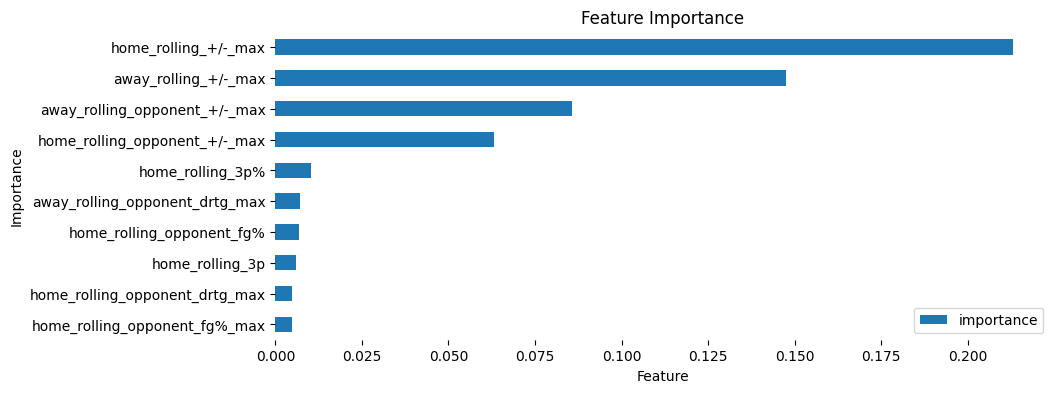

In [5]:
rf_best_features =  get_feature_importance(rf[-1].feature_importances_, X.columns, n_best_features=10)

### Estimating the n principal components that explain the most part of the model variance

In [25]:
from sklearn.decomposition import PCA

def pca_metrics(model, X_train=X_train_scaled, X_test=X_test_scaled, y_train=y_train, y_test=y_test, n_components=0.95):
    """ Info:
     This function takes a model and returns the metrics reports of the model with the PCA.
      -----------------------------------------------------------------------------------------------------------------
       Input:
        model: The model to be used.
        X_train: The training set.
        X_test: The testing set.
        y_train: The training target.
        y_test: The testing target.
        n_components: The number of components to be used in the PCA.
        -----------------------------------------------------------------------------------------------------------------
        Output:
         classification_report: The classification report of the model with the PCA.
        """
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)
    #get the number of components
    n_components = pca.n_components_
    

    return classification_report(y_test, y_pred), n_components

In [26]:
#pca 95% variance explained
#1 - linear regression model
models = [lr, svm, rf, gbc]

for model in models:
    print('{}\n'.format(model[1]), pca_metrics(model)[0])
    print('Principal components used: {}\n'.format(pca_metrics(model)[1]))



LogisticRegression(C=0.001, max_iter=10000, random_state=42, solver='sag')
               precision    recall  f1-score   support

           0       0.77      0.54      0.64       541
           1       0.70      0.87      0.77       659

    accuracy                           0.72      1200
   macro avg       0.74      0.71      0.71      1200
weighted avg       0.73      0.72      0.71      1200

Principal components used: 109

LinearSVC(C=0.0001, max_iter=100000, random_state=42)
               precision    recall  f1-score   support

           0       0.72      0.64      0.68       541
           1       0.73      0.80      0.76       659

    accuracy                           0.73      1200
   macro avg       0.72      0.72      0.72      1200
weighted avg       0.73      0.73      0.72      1200

Principal components used: 109

RandomForestClassifier(criterion='entropy', max_depth=10, max_features=None,
                       max_leaf_nodes=30, min_samples_split=10,
          

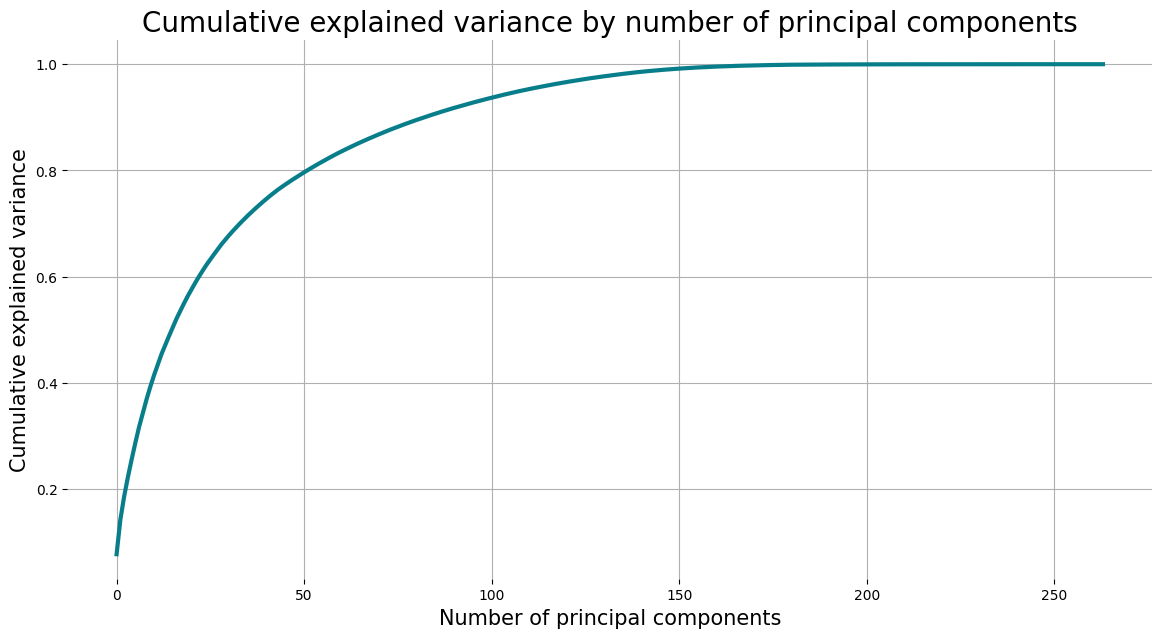

In [23]:


pca = PCA().fit(X_train_scaled)

plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3, color='#087E8B') # type: ignore // cumulative explained variance
plt.xlabel('Number of principal components', size=15)
plt.ylabel('Cumulative explained variance', size=15)
plt.grid(True)
plt.title('Cumulative explained variance by number of principal components', size=20)
plt.show()

In [27]:
# using 100 principal components to train and test our models
models = [lr, svm, rf, gbc]

for model in models:
    print('{}\n'.format(model[1]), pca_metrics(model, n_components=100)[0])
    print('Principal components used: {}\n'.format(pca_metrics(model, n_components=100)[1]))

LogisticRegression(C=0.001, max_iter=10000, random_state=42, solver='sag')
               precision    recall  f1-score   support

           0       0.78      0.55      0.64       541
           1       0.70      0.88      0.78       659

    accuracy                           0.73      1200
   macro avg       0.74      0.71      0.71      1200
weighted avg       0.74      0.73      0.72      1200

Principal components used: 100

LinearSVC(C=0.0001, max_iter=100000, random_state=42)
               precision    recall  f1-score   support

           0       0.72      0.64      0.68       541
           1       0.73      0.80      0.76       659

    accuracy                           0.73      1200
   macro avg       0.73      0.72      0.72      1200
weighted avg       0.73      0.73      0.72      1200

Principal components used: 100

RandomForestClassifier(criterion='entropy', max_depth=10, max_features=None,
                       max_leaf_nodes=30, min_samples_split=10,
          

We can now associate the principal components to our features to see how relevant they are for the PCA, meaning that the more correlated, the more that feature explain the results. As the first principal component is the most relavant, lets just consider the first col

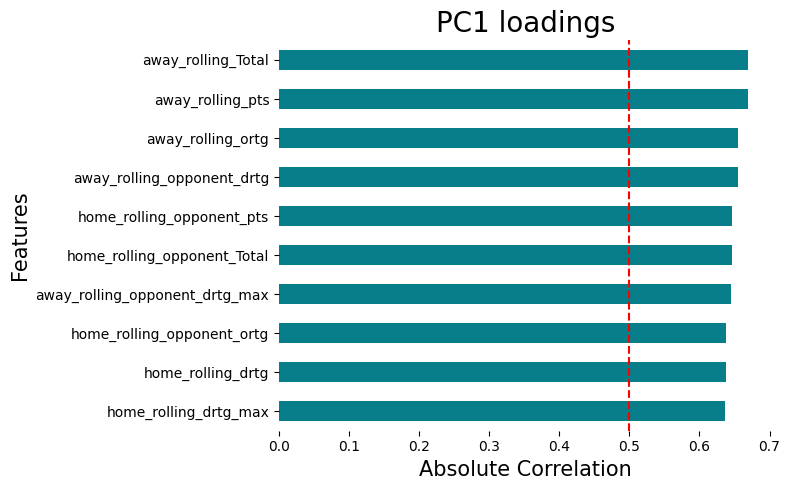

away_rolling_Total                0.669218
away_rolling_pts                  0.669218
away_rolling_ortg                 0.654544
away_rolling_opponent_drtg        0.654544
home_rolling_opponent_pts         0.646295
home_rolling_opponent_Total       0.646295
away_rolling_opponent_drtg_max    0.645608
home_rolling_opponent_ortg        0.637927
home_rolling_drtg                 0.637927
home_rolling_drtg_max             0.637117
Name: PC1, dtype: float64

In [30]:
plt.figure(figsize=(8, 5))

loadings = pd.DataFrame(
    data=pca.components_.T * np.sqrt(pca.explained_variance_), #type: ignore
    columns=[f'PC{i}' for i in range(1, len(X_train.columns) + 1)], #type: ignore
    index=X_train.columns #type: ignore
)
loadings['PC1'] = abs(loadings['PC1'])
#picking the 100 best featues accordnly to PCA 1
pca_best_features = loadings['PC1'].sort_values(ascending=False).head(10)

pca_best_features[::-1].plot(kind='barh', color='#087E8B')
plt.title('PC1 loadings', size=20)
plt.ylabel('Features', size=15)
plt.xlabel('Absolute Correlation', size=15)

#drawing a line at 0.5
plt.axvline(x=0.5, color='red', linestyle='--')
plt.tight_layout()
plt.show()

pca_best_features.head(10)

Comparing the best features for each

In [20]:
df_best_features = pd.DataFrame([rf_best_features.index, pca_best_features.index]).T
df_best_features.columns = ['Random Forest', 'PCA']
df_best_features.head(10)

,Random Forest,PCA
0,home_rolling_+/-_max,away_rolling_pts
1,away_rolling_+/-_max,away_rolling_Total
2,away_rolling_opponent_+/-_max,away_rolling_opponent_drtg
3,home_rolling_opponent_+/-_max,away_rolling_ortg
4,home_rolling_3p%,home_rolling_opponent_pts
5,away_rolling_opponent_drtg_max,home_rolling_opponent_Total
6,home_rolling_opponent_fg%,away_rolling_opponent_drtg_max
7,home_rolling_3p,home_rolling_opponent_ortg
8,home_rolling_opponent_drtg_max,home_rolling_drtg
9,home_rolling_opponent_fg%_max,home_rolling_drtg_max


Nice insight! We can see that the combination of the players impact are what impacts the most on our predictive models, except PCA. Now, lets see if that will be the case again after performing feature selection using the exaustive away from sklearn. As an alternative, you could just use like the 30 best features for each model. 

## Note:

* Sklearn says that:

"To finish with, we should note that SelectFromModel is significantly faster than SFS. Indeed, SelectFromModel only needs to fit a model once, while SFS needs to cross-validate many different models for each of the iterations. SFS however works with any model, while SelectFromModel requires the underlying estimator to expose a coef_ attribute or a feature_importances_ attribute." The forward SFS is faster than the backward SFS because it only needs to perform n_features_to_select = 2 iterations, while the backward SFS needs to perform n_features - n_features_to_select = 8 iterations."

* However:

As the faster selection sees only the feature importances, it is like if we did what we just did and select the top features. But in our case, could be that some features perform better in conjunction with other features that are not that important. As we cant say otherwise for now, we are going to take the safe route and do the exaustive selection.

# Performing exaustive feature selection

For the 2 linear models, we are going to use the subset of features found by logistic regression.
For the 2 emsemble models, we are going to use the subset found by random forest.
Thats the main goal. The number of subsets will change in a iterative fashion. We started giving the models the full featured data set, so they return us the best hyperparameters for each model. Then, we use these models to find the n best features. Then  we find the best hyperparameters within that subset, and so on until we cant increase more the ROC AUC score.

We are going to specify that, the selector will choose only n features, starting with 100.

In [15]:
from sklearn.feature_selection import SequentialFeatureSelector
from time import time
import os

def select_nBest_features(model, n_features):
    """ Info:
     Choose a model and a number of features to select the best features among this number, saving the results in a csv file,
     plots the top n_best_features and returns a dataframe with the feature importance.
     As the method dont return the importances, just the most important features, we need to get to that after the selection. 
      -----------------------------------------------------------------------------------------------------------------
       Input:
        model: The model to be used.
        n_features: The number of best features to select
        -----------------------------------------------------------------------------------------------------------------
            Output:
                Best features for the chosen model.
                
            """
    #verifies if the model is saved already to proceed with the selection
    if not os.path.isfile(f'best_features/{model[-1].__class__.__name__}_{n_features}.csv'): # model[-1] is the model itself in the pipeline
        start = time()
        sfs = SequentialFeatureSelector(model[-1], n_features_to_select=n_features, direction='backward', scoring='accuracy', cv=5, n_jobs=-1)
        sfs.fit(X, y)
        end = time()
        print(f"Features selected by forward sequential selection: {X.columns[sfs.get_support()]}") #feature names for the best features
        print(f'Minutes elapsed: {round((end - start)/60)}') #time in minutes
        #saving the best features to csv
        pd.Series(X.columns[sfs.get_support()]).to_csv(f'best_features/{model[-1]}_{n_features}.csv', index=False)
    else:
        print(f'Best {n_features} features for {model[-1].__class__.__name__} already saved.')

    #loading the best features for plotting
    return pd.read_csv(f'best_features/{model[-1].__class__.__name__}_{n_features}.csv', header=None) 
    
   



## Best features using Logistic regression to select the most important features for all models

## Logistic Regression
n_features = 100

In [16]:
# Logistic Regression
#we need to pass the model pipeline, and the number of features to select
best_features_lr = select_nBest_features(lr, 100)
best_features_lr

Best 100 features for LogisticRegression already saved.


,0
0,0
1,home_rolling_fg
2,home_rolling_fg%
3,home_rolling_3p
4,home_rolling_3p%
...,...
96,away_rolling_opponent_+/-_max
97,away_rolling_opponent_efg%_max
98,away_rolling_opponent_ast%_max
99,away_rolling_opponent_drtg_max


n_features = 50

In [17]:
# Logistic Regression
best_features_lr = select_nBest_features(lr, 50)
best_features_lr

Best 50 features for LogisticRegression already saved.


,0
0,0
1,home_rolling_ft
2,home_rolling_drb
3,home_rolling_pts
4,home_rolling_orb%
5,home_rolling_ast%
6,home_rolling_trb_max
7,home_rolling_pts_max
8,home_rolling_+/-_max
9,home_rolling_drb%_max


Best 100 features accordnly with PCA

In [21]:
df_best_features['PCA']

0                  away_rolling_pts
1                away_rolling_Total
2        away_rolling_opponent_drtg
3                 away_rolling_ortg
4         home_rolling_opponent_pts
                  ...              
95                 away_rolling_3p%
96        home_rolling_opponent_3p%
97    home_rolling_opponent_fg%_max
98                 home_rolling_fta
99        away_rolling_opponent_3p%
Name: PCA, Length: 100, dtype: object

In [23]:

df_best_features['PCA'].to_csv(f'best_features/PCA_{100}.csv', index=False)